<a href="https://colab.research.google.com/github/yajuna/pinn_heat/blob/master/heat_pinn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook solves the heat equation in cylindrical coordinates with a physics informed neural network.
We train the neural network with temperature data collected in onsite, and incorporate weather condition as source term.

The physics informed neural network is based on previous work done by Raissi et al, and a comprehensive review by Blechschmidt and Ernst. This notebook is based on the tensorflow 2 implementation by Blechschmidt and Ernst.

Consider the 1 dimensional heat equation

$\rho c \frac{\partial T}{\partial t}=\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$,

together with initial and boundary conditions

$T_{t=0} = T_{init}$, $T|_{\partial D} = T_b$, we construct a neural network that incorporates the residual of the PDE (as physics information):

residual = $\frac{\partial T}{\partial t}-\frac{k}{\rho c }\frac{1}{r}\frac{\partial T}{\partial r}-\frac{k}{\rho c}\frac{\partial^2 T}{\partial r^2}-\frac{1}{\rho c}\text{source terms}$

The source term includes three terms: solar radiation, long radiation, as well as heat convection.

## Import packages

This computation mostly requires the ``numpy`` library, as well as ``tensorflow 2``. Visualization is done with ``matplotlib``.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time
from IPython.display import clear_output

clear_output()

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Tensorflow version is", tf.__version__)
print("Numpy version is", np.__version__)

Python 3 version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Matplotlib version is 3.7.1
Tensorflow version is 2.15.0
Numpy version is 1.23.5


## Set data type and hyperparameters
N_0: number of points in space
N_b: number of points in time
N_r: number of points within the space time domain

We solve the heat equation in a 24 hour period, and boundary conditions are measured on a mango tree with radius 0.135 m.

Initial condition is interpolated at ``X_0``; inner boundary condition is measured at ``X_lb``; outer boundary condition is measured at ``X_ub``. A set of collocation points are generated uniformly randomly, and stored in ``X_r``.

Two additional set of measured data sets are recorded at ``X_train`` and ``X_train1``. These correspond to temperature data measured at 9cm depth and 4.5cm depth in the tree trunk.

Here we take ``X_0 = X_b`` for the simplicity of concatenation, following Blechschmidt and Ernst.

$\sigma$ and albedo are heat parameters used in the source terms.

A random seed is set for reproducibility.

In [ ]:
# set data type and hyperparameters

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype = DTYPE)

# Set number of data points
N_0 = 412 # number of points in space; same as N_0 for simplicity
N_b = 412 # number of points in time; this is the amount of measurements in 24 hours
N_r = 1000

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.001
xmax = 0.135

# # surface source to volume source
# delta_r = (xmax - xmin) / N_b
# coeff_surface = 1. / delta_r

# heat parameters
sigma = 5.76e-8
albedo = 0.3

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left to be core temperature, and right the bark temperature
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

## Add extra training data at X_train (location at midTemp1)
idx = int(N_0 / 3)
x_train = tf.ones((N_0,1), dtype=DTYPE) * x_init[idx]
X_train = tf.concat([t_b, x_train], axis=1)
x_train1 = tf.ones((N_0,1), dtype=DTYPE) * x_init[2 * idx]
X_train1 = tf.concat([t_b, x_train1], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

## Count the index of data on August 21.
``train_tree_temp_index`` finds measured temperature data in temperature spreadsheet
``train_weather_index`` finds recorded weather data to use in source terms.

In [ ]:
##### ave tree temp and weather temp for future reference
train_tree_temp_index = 416 - 2
train_interp_temp_size = train_tree_temp_index

train_weather_index = 145 - 2
train_interp_weather_size = train_weather_index

## Import temperature data used to train the neural network

In [ ]:
##### measured tree temperature for initial and boundary conditions. Need fixing
colnames_tree_temp = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/pinn_heat/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames_tree_temp)

### training temperature data
# core temp is west, at 13.5cm, at 2m high
train_coreTemp = np.array(dataTemp.s135_3[2: train_tree_temp_index])#+ 273.15
# West, at 9cm, at 3m high
train_midTemp1 = np.array(dataTemp.w9_3[2: train_tree_temp_index])#+ 273.15
# North, at 4.5cm, at 3m high
train_midTemp2 = np.array(dataTemp.n45_3[2: train_tree_temp_index])#+ 273.15
# bark temp is West, at bark, at 3.5m high
train_barkTemp = np.array(dataTemp.w_ext_35[2: train_tree_temp_index])#+ 273.15

train_initTemp = np.array([train_coreTemp[0], train_midTemp1[0], train_midTemp2[0], train_barkTemp[0]])
train_init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,train_initTemp.size),train_initTemp)


## Construct training data ``u_data`` at ``X_data``.

In [ ]:
u_0 = train_init_temp
u_lb = train_coreTemp
u_ub = train_barkTemp
u_train = train_midTemp1
u_train1 = train_midTemp2

# collect initial and two boundary data in lists # add training data and points
X_data = [X_0, X_lb, X_ub ]#, X_train]#, X_train1]
u_data = [u_0, u_lb, u_ub ]#, u_train]#, u_train1]

## Read weather data and compute source term

In [ ]:
colnames_weather = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/pinn_heat/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames_weather)

nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707
ka = 26.3e-3 # W/mK conductivity of air
coeff = 2 * xmax / nu

#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])#+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

train_airTemp = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_solar)



Re_train = train_windSpeed * coeff
C_train = []
m_train = []
for j in range(train_windSpeed.size):
    temp = Re_train[j]
    if temp < 0.4:
        temp1 = [0, 0]
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C_train.append(temp1[0])
    m_train.append(temp1[1])

Nu_train = C_train * Re_train ** m_train * Pr ** (1/3)
h_train = Nu_train * ka / (2 * xmax)

convect_train = h_train * (u_ub - train_airTemp)
sourceTerm_train = (1 - albedo) * train_solar + sigma * (train_airTemp**4 - u_ub**4) + convect_train


## Define parameters for the heat equation.

Here
$k=0.12$ is the heat conductivity
$c = 1380$ is the heat capacity
$\rho = 510$ is the density of mango trees

In [ ]:
lambd1 = 0.12/(1380 * 510)
lambd2 = 1./(1380 * 510)

## Set up architecture of neural network
The default neural network has 8 hidden layers, with 20 neurons per layer.

The input is two dimensional, consisting of time and space variable.

First hidden layer is a scaling layer that maps the input from ``[lb, ub]`` to [-1,1].

8 hidden layers are appended- each with ``tanh`` activation function.

The output layer is one dimensional solution of the temperature.

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input from [lb, ub] to [-1,1]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional computed temperature
    model.add(tf.keras.layers.Dense(1))

    return model

## Compute residual of the PDE with tensorflow's ``gradiant tape``.

$u$ and $u_x$ are computed within the tape, to enable computation of $u_t$ and $u_{xx}$.

The function ``get_r`` takes a neural network and space time points, and returns the residual

residual = $\frac{\partial T}{\partial t}-\frac{k}{\rho c }\frac{1}{r}\frac{\partial T}{\partial r}-\frac{k}{\rho c}\frac{\partial^2 T}{\partial r^2}-\frac{1}{\rho c}\text{source terms}$

at the given space time points $X$.


In [ ]:
def get_r(model, X)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X[:, 0:1], X[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return u_t - 1./x * lambd1 * u_x - lambd1 * u_xx - lambd2 * sourceTerm_train

 Test cells with model, residual and compute reduce mean. Commented out after testing.

In [ ]:
# model = init_model(num_hidden_layers = 2)
# r = get_r(model, X_0)
# phi_r = tf.reduce_mean(tf.square(r))

## Compute loss from the neural network.

Loss is the sum of the following terms-

1. ``phi_r``: the residual at the interior points ``X_r``.

2. At ``X_0``, ``X_lb`` and ``X_ub``, we compute predicted temperature with PINN model, then compute the mean square loss of $u_{true} - u_{pred}$

Total loss is the sum of the above two terms.

In [ ]:
def compute_loss(model, X_r, X_data, u_data)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error loss; add boundary loss

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

        return loss

    ## define customized loss-- max(abs(u_data and u_pred))


    return loss

Testing cell for loss. Commented out after testing

In [ ]:
# loss = compute_loss(model, X_r, X_data, u_data)

## Compute gradient with respect to trainable variables of the Neural Network.

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## Define model and learning rate
Initialize model with two hidden layers; Define learning rate for gradient descent algorithm to be a piecewise constant function that decays in the following way.

1. The first 1000 steps use a learning rate of 0.01.

2. From 1000 - 3000: learning rate = 0.001

3. From 3000 onwards: learning rate = 0.0005


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                60        
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 501 (1.96 KB)
Trainable params: 501 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


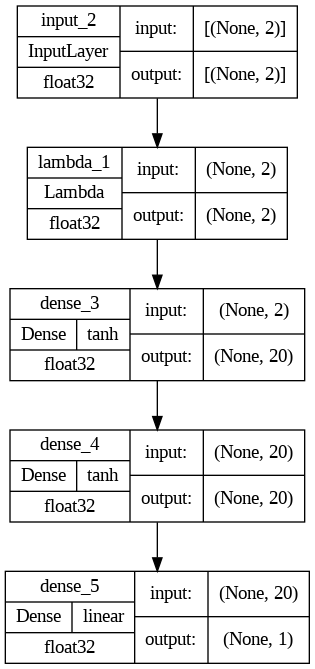

In [ ]:
# Initialize model
model = init_model(num_hidden_layers = 2)

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True,
                          show_layer_names=True, show_dtype=True,
                          show_layer_activations=True)


## Training
We observe convergence by looking at the loss function. We experimemt with Kelvin as well as Celsius as unit for temperatures. We observe
convergence within a few hundred epochs with Celsius, and a few thousand with Kelvin. The observed limit of loss is about 4.4e-1.

We have implemented Celsius for quick testing.

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 1000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 6.47041626e+02
It 00050: loss = 1.08326782e+02
It 00100: loss = 1.51740866e+01
It 00150: loss = 1.26211774e+00
It 00200: loss = 5.10647714e-01
It 00250: loss = 4.73313630e-01
It 00300: loss = 4.60920721e-01
It 00350: loss = 4.54346120e-01
It 00400: loss = 4.50340152e-01
It 00450: loss = 4.47680026e-01
It 00500: loss = 4.45805639e-01
It 00550: loss = 4.44425732e-01
It 00600: loss = 4.43375170e-01
It 00650: loss = 4.42553580e-01
It 00700: loss = 4.41896886e-01
It 00750: loss = 4.41362381e-01
It 00800: loss = 4.40920651e-01
It 00850: loss = 4.40550655e-01
It 00900: loss = 4.40237194e-01
It 00950: loss = 4.39969122e-01
It 01000: loss = 4.39737618e-01

Computation time: 8.559262037277222 seconds


## Visualization
Loss history is plotted as a function of epoch.

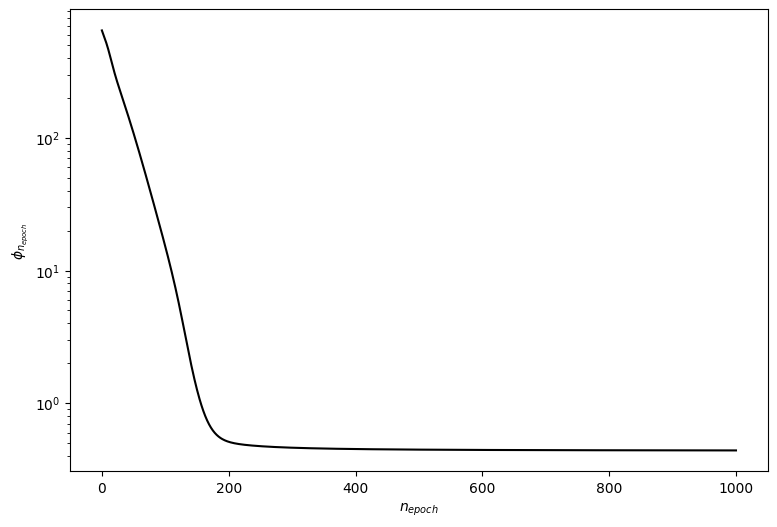

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');